# Network Visualization

This notebook visualizes the initial entire network, and subsequently the backbone of the network from the DayZero goal co-occurrence network. The backbone shows only the most structurally significant connections. This notebook requires the [backboning.py](https://www.michelecoscia.com/?page_id=287) file to be in the same location.

In [1]:
import requests
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 18)

## 1. Load Networks

Load both the original network and create the backbone network using the same methodology as in `connect.ipynb`.

In [2]:
# Load the full network
url = "https://raw.githubusercontent.com/nicosrp/The-Architecture-of-Aspiration-A-Network-Perspective-on-Human-Goals/main/Networks/dayzero_network.pkl"
response = requests.get(url)
response.raise_for_status()
G = pickle.loads(response.content)

print(f"Full network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Full network: 2890 nodes, 219130 edges


In [3]:
# Get largest connected component
components = list(nx.connected_components(G))
G_largest = G.subgraph(max(components, key=len)).copy()

## 2. Full Network Visualization

Before visualizing the backbone, we visualize the largest component of the entire network, and color the nodes based on their category assignment from the previous classification

In [4]:
# Prepare category colors for the full network
print("Preparing full network visualization...")

# Get all categories
all_categories = []
for node in G_largest.nodes():
    cat = G_largest.nodes[node].get('category', 'Unknown')
    all_categories.append(cat)

unique_categories = sorted(set(all_categories))
if 'Unknown' in unique_categories:
    unique_categories.remove('Unknown')
    unique_categories.append('Unknown')

print(f"\nFound {len(unique_categories)} categories:")
for cat in unique_categories:
    count = all_categories.count(cat)
    print(f"  • {cat}: {count} goals")

# Create modern color palette
colors = plt.cm.tab20c(np.linspace(0, 1, len(unique_categories)))
category_colors = {cat: colors[i] for i, cat in enumerate(unique_categories)}

# Assign colors to nodes
node_colors_full = [category_colors[cat] for cat in all_categories]

Preparing full network visualization...

Found 16 categories:
  • Academic and professional achievements: 2 goals
  • Acts of kindness/altruism: 4 goals
  • Creativity: 6 goals
  • Events & concerts: 254 goals
  • Experiences: 81 goals
  • Food: 96 goals
  • Health: 17 goals
  • Media consumption: 74 goals
  • Nature: 288 goals
  • New skills: 105 goals
  • Places of interest: 863 goals
  • Relationships & social life: 8 goals
  • Religion: 17 goals
  • Sports: 45 goals
  • Travel destinations: 999 goals
  • Unknown: 1 goals


In [5]:
# Calculate layout for the full network (this may take a moment with 3000 nodes)
print("\nCalculating network layout...")

try:
    # Try ForceAtlas2 (faster and better for large networks)
    from fa2 import ForceAtlas2
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=False
    )
    pos_full = forceatlas2.forceatlas2_networkx_layout(G_largest, pos=None, iterations=100)
    print("Layout calculated using ForceAtlas2")
except ImportError:
    # Fallback to spring layout
    pos_full = nx.spring_layout(G_largest, k=1/np.sqrt(len(G_largest.nodes())), iterations=50, seed=42)
    print("Layout calculated using spring layout")


Calculating network layout...
Layout calculated using spring layout


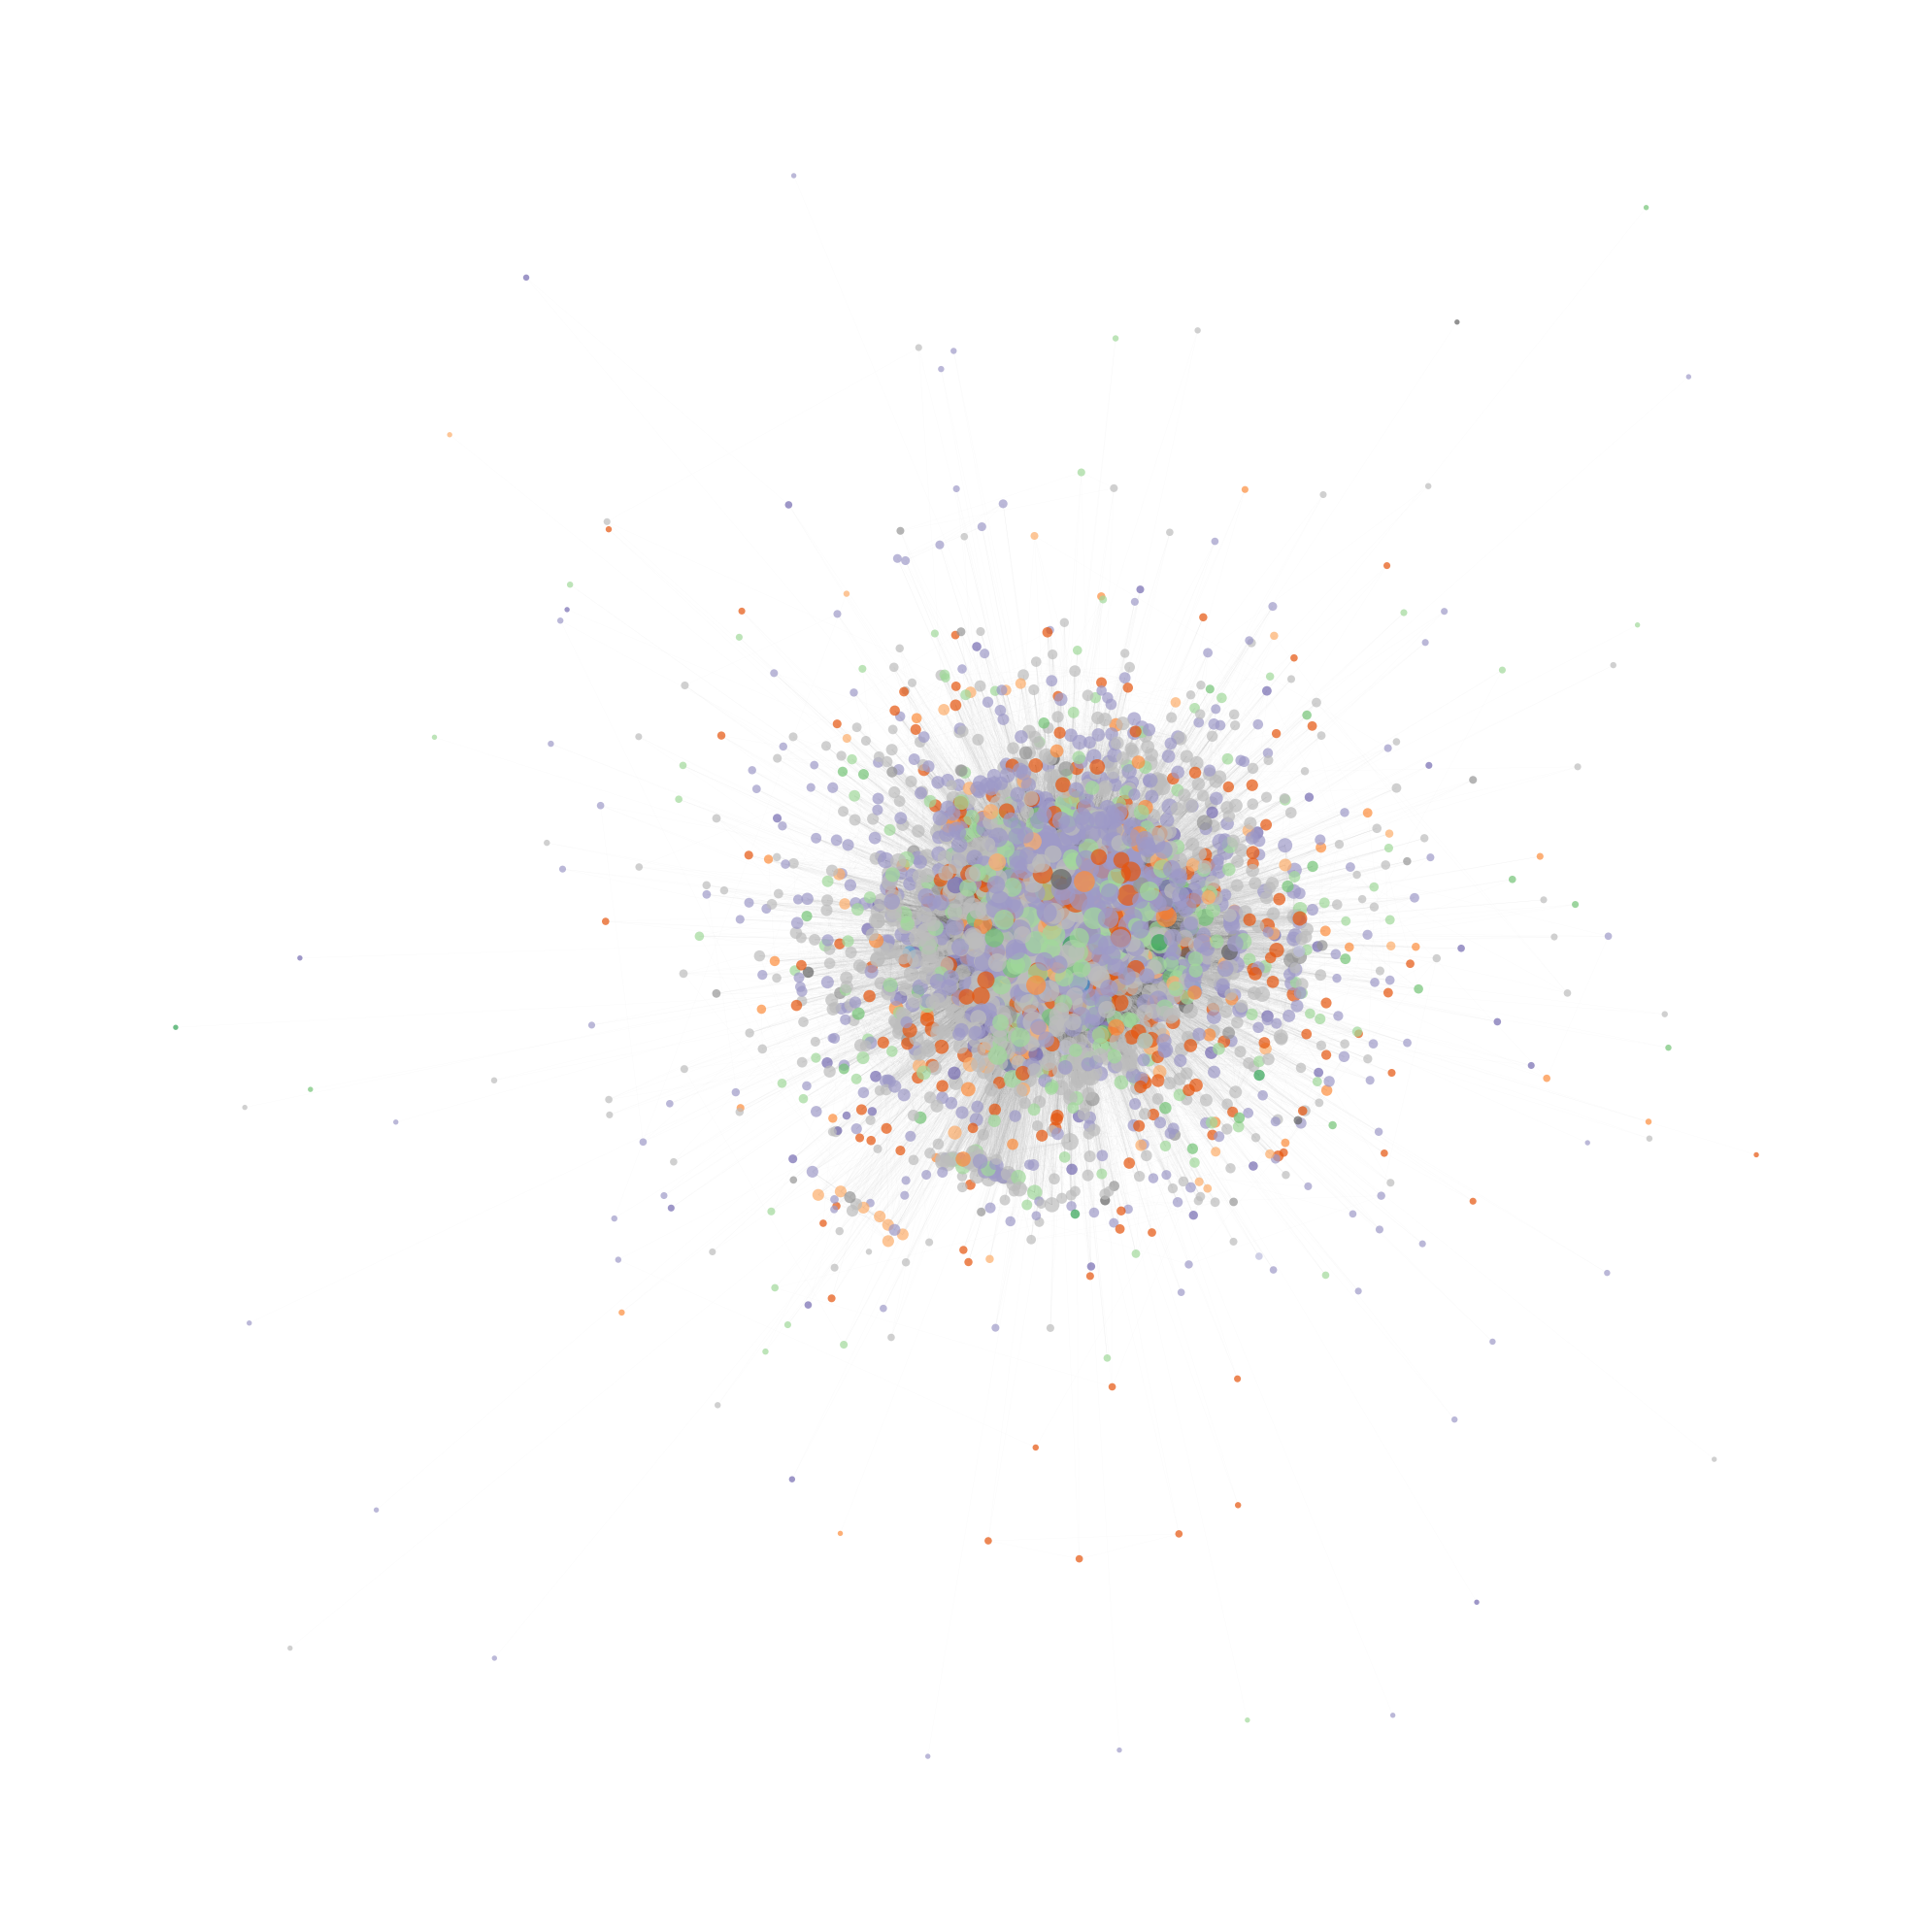


Network Statistics:
  Nodes: 2860
  Edges: 219126
  Average degree: 153.2
  Density: 0.0536


In [6]:
# Visualize the full network with modern styling
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='white')

# Calculate node sizes based on degree (scaled down for large network)
degrees = dict(G_largest.degree())
node_sizes = [np.sqrt(degrees[node]) * 15 for node in G_largest.nodes()]

# Draw edges with low opacity to avoid hairball effect
nx.draw_networkx_edges(
    G_largest, 
    pos_full, 
    alpha=0.02,
    width=0.3,
    edge_color='#666666',
    ax=ax
)

# Draw nodes with category colors
nx.draw_networkx_nodes(
    G_largest,
    pos_full,
    node_color=node_colors_full,
    node_size=node_sizes,
    alpha=0.7,
    linewidths=0,
    ax=ax
)

ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nNetwork Statistics:")
print(f"  Nodes: {len(G_largest.nodes())}")
print(f"  Edges: {len(G_largest.edges())}")
print(f"  Average degree: {np.mean(list(degrees.values())):.1f}")
print(f"  Density: {nx.density(G_largest):.4f}")

Next, we include a degree filter, to only include those nodes with a degree of 50 or higher.


Filtered network with degree >= 50:
  Nodes: 1868 (from 2860)
  Edges: 199175 (from 219126)


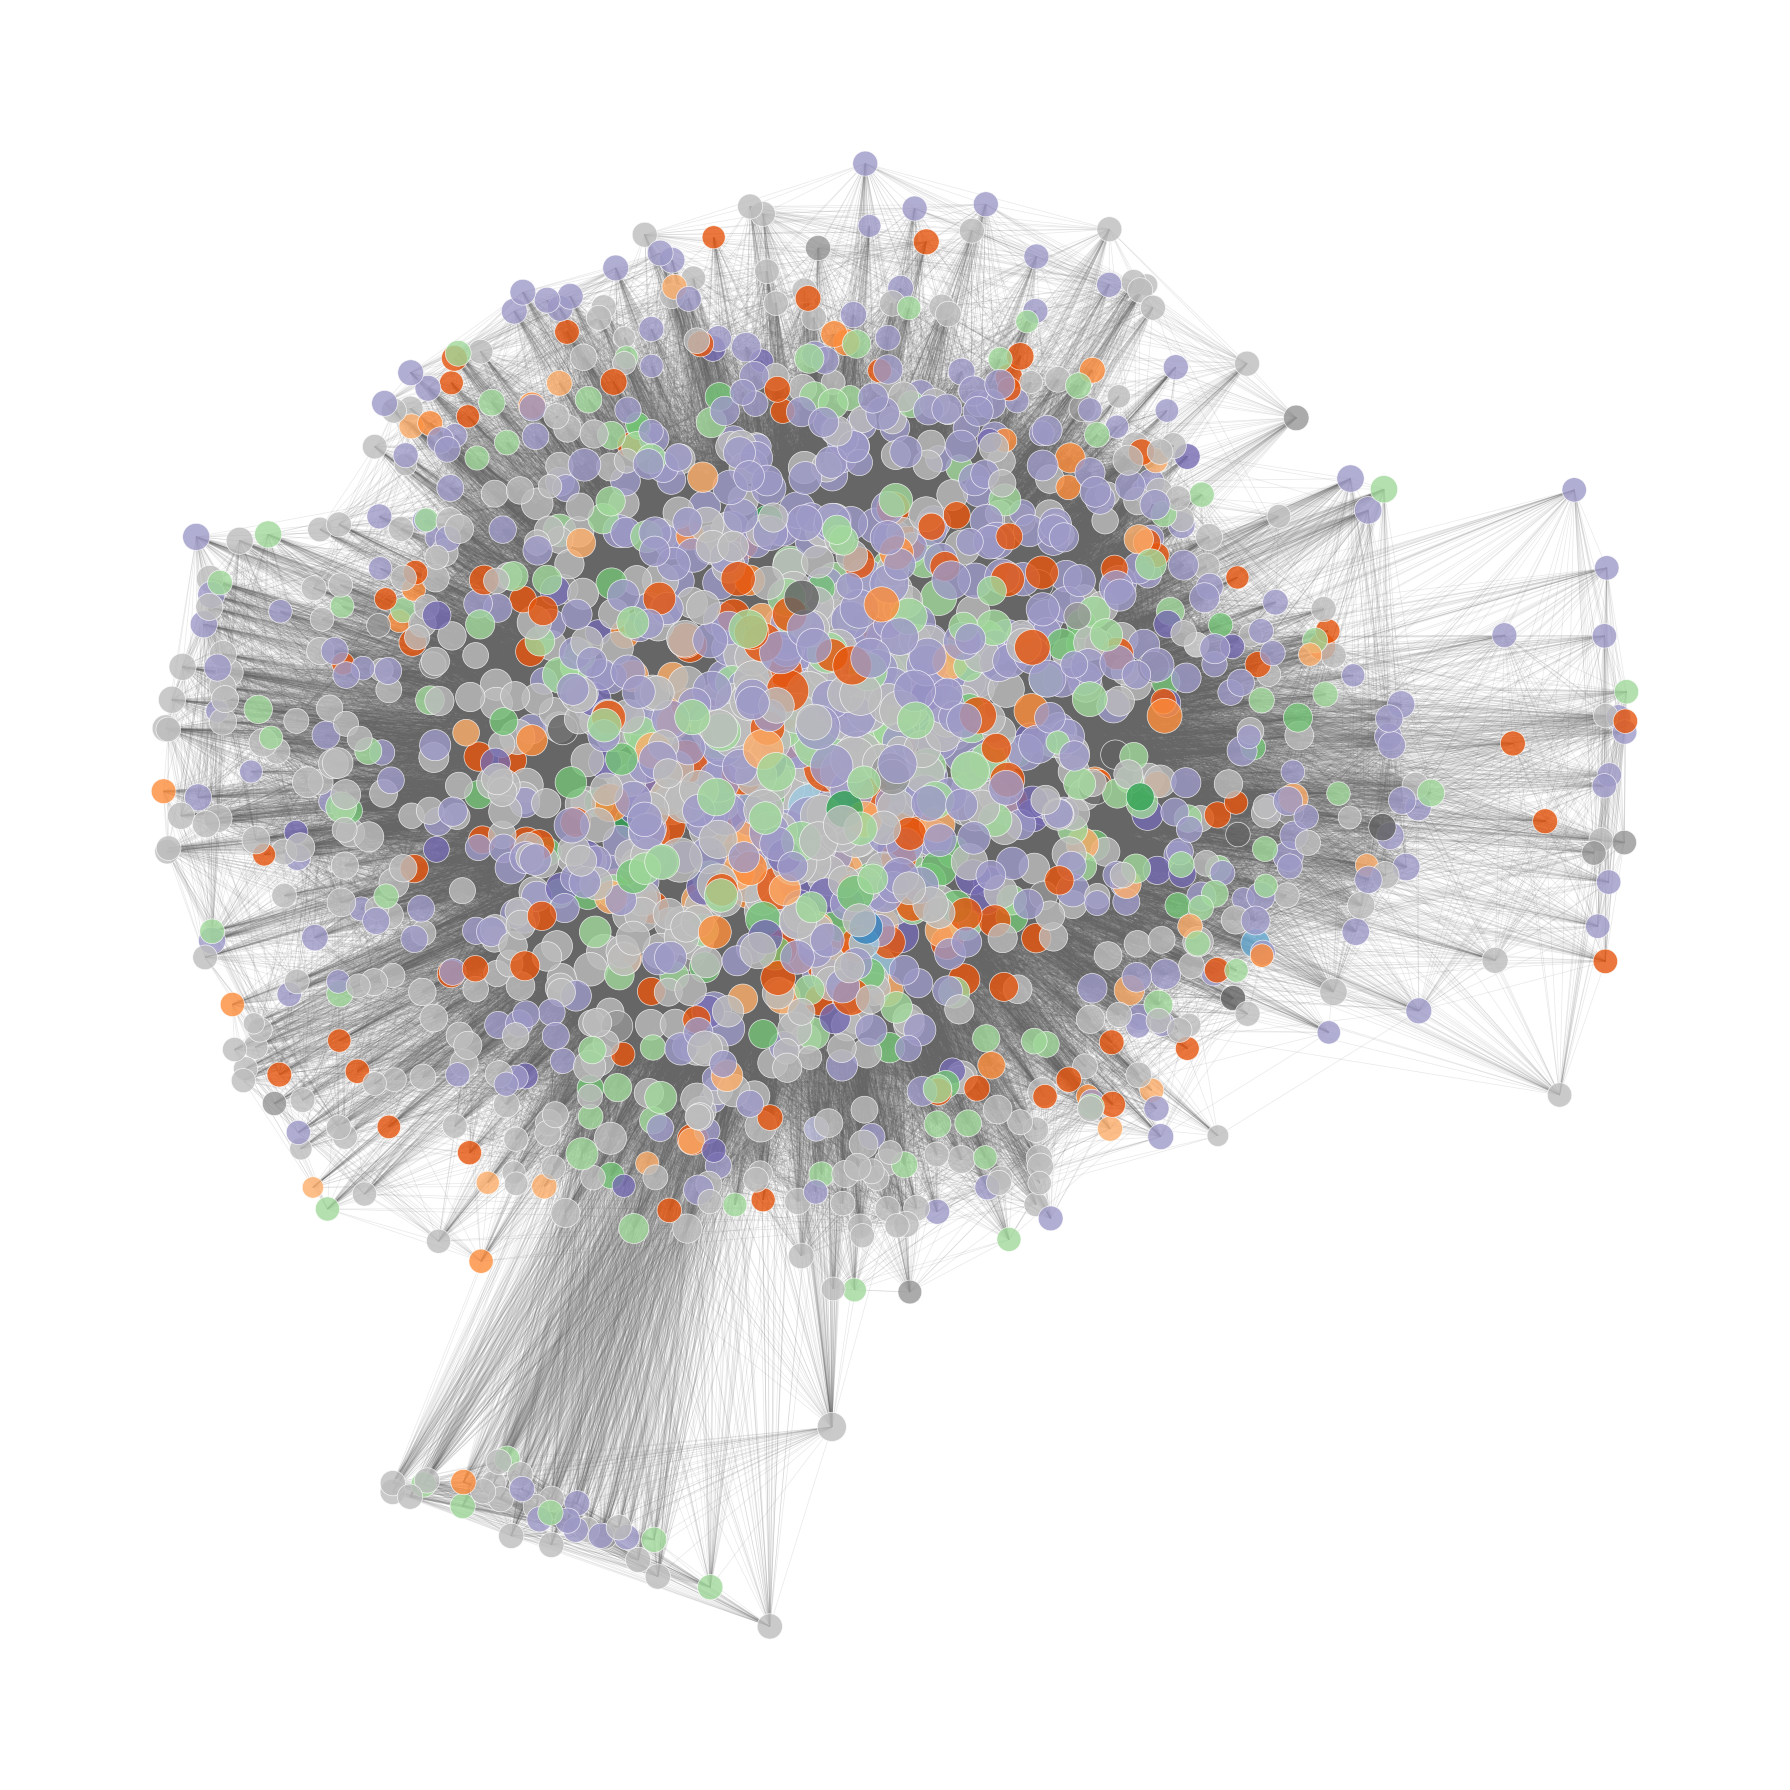

In [7]:
# Alternative visualization: Show only high-degree nodes for clearer structure
fig, ax = plt.subplots(1, 1, figsize=(18, 18), facecolor='white')

# Filter to nodes with degree >= 50 for clearer visualization
degree_threshold = 50
high_degree_nodes_set = {node for node, deg in degrees.items() if deg >= degree_threshold}
G_filtered = G_largest.subgraph(high_degree_nodes_set).copy()

print(f"\nFiltered network with degree >= {degree_threshold}:")
print(f"  Nodes: {len(G_filtered.nodes())} (from {len(G_largest.nodes())})")
print(f"  Edges: {len(G_filtered.edges())} (from {len(G_largest.edges())})")

# Get filtered positions
pos_filtered = {node: pos_full[node] for node in G_filtered.nodes()}

# Get colors for filtered nodes
filtered_categories = [G_filtered.nodes[node].get('category', 'Unknown') for node in G_filtered.nodes()]
node_colors_filtered = [category_colors[cat] for cat in filtered_categories]

# Node sizes based on degree
filtered_degrees = dict(G_filtered.degree())
node_sizes_filtered = [np.sqrt(filtered_degrees[node]) * 40 for node in G_filtered.nodes()]

# Draw edges
nx.draw_networkx_edges(
    G_filtered, 
    pos_filtered, 
    alpha=0.15,
    width=0.5,
    edge_color='#666666',
    ax=ax
)

# Draw nodes
nx.draw_networkx_nodes(
    G_filtered,
    pos_filtered,
    node_color=node_colors_filtered,
    node_size=node_sizes_filtered,
    alpha=0.8,
    linewidths=0.5,
    edgecolors='white',
    ax=ax
)

ax.axis('off')

plt.tight_layout()
plt.show()

## 2. Side-by-Side Comparison

After having looked at the full network and the degree filtered network, we now visualize the backbone of the network. The initial visulizations showed, that keeping all nodes and edges for the visualization can make it look like a hairball. Now, with the backbone visualization we aim to keep only the most structurally significant connections. 

In [8]:
# Calculate edge betweenness centrality
ebc = nx.edge_betweenness_centrality(G_largest)

# Normalize to range [1, 100]
min_weight = min(ebc.values())
max_weight = max(ebc.values())
weights_scaled = {edge: 1 + 99*(val - min_weight)/(max_weight - min_weight) 
                  for edge, val in ebc.items()}

# Create weighted network
G_weighted = G_largest.copy()
nx.set_edge_attributes(G_weighted, weights_scaled, 'weight')

print(f"Edge weights created: {min(weights_scaled.values()):.2f} to {max(weights_scaled.values()):.2f}")

Edge weights created: 1.00 to 100.00


We apply a disparity filter with a threshold of 0.4., keeping 29.4 % of the original nodes and 0.4 % of original edges.

In [9]:
# Apply disparity filter
import contextlib
import io

try:
    import backboning
    
    # Prepare edge table
    edge_table = nx.to_pandas_edgelist(G_weighted)
    edge_table.rename(columns={'source': 'src', 'target': 'trg', 'weight': 'nij'}, inplace=True)
    
    # Apply disparity filter
    print("Applying disparity filter...")
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        df_table = backboning.disparity_filter(edge_table)
    
    # Filter by threshold
    threshold = 0.4
    df_table_filtered = df_table[df_table['score'] < threshold]
    
    # Create backbone graph
    G_backbone = nx.from_pandas_edgelist(df_table_filtered, 'src', 'trg', edge_attr='nij')
    
    # Copy node attributes
    for node in G_backbone.nodes():
        if node in G_largest.nodes():
            G_backbone.nodes[node].update(G_largest.nodes[node])
    
    print(f"\nBackbone extracted (α={threshold}):")
    print(f"  Nodes: {G_backbone.number_of_nodes()} ({100*G_backbone.number_of_nodes()/G_weighted.number_of_nodes():.1f}% of original)")
    print(f"  Edges: {G_backbone.number_of_edges()} ({100*G_backbone.number_of_edges()/G_weighted.number_of_edges():.1f}% of original)")
    print(f"  Density: {nx.density(G_backbone):.4f} (original: {nx.density(G_weighted):.4f})")
    
except ImportError:
    print("ERROR: backboning module not found!")
    print("Please ensure backboning.py is in the directory.")
    print("Download from: https://www.michelecoscia.com/?page_id=287")
    G_backbone = None

Applying disparity filter...

Backbone extracted (α=0.4):
  Nodes: 842 (29.4% of original)
  Edges: 814 (0.4% of original)
  Density: 0.0023 (original: 0.0536)


In the visualization below, we visualize a version of the full network, next to our backbone network. To account for the original network to be loaded with a large amount of nodes, we decreased the node size there. The purpose of this plot is to show that the backbone visualization in fact does a good job in breaking down the more messy and loaded network visualization on the left, into a visualization that seems to disentangle this mess through node and edge reduction while keeping structural relevant nodes and connections.

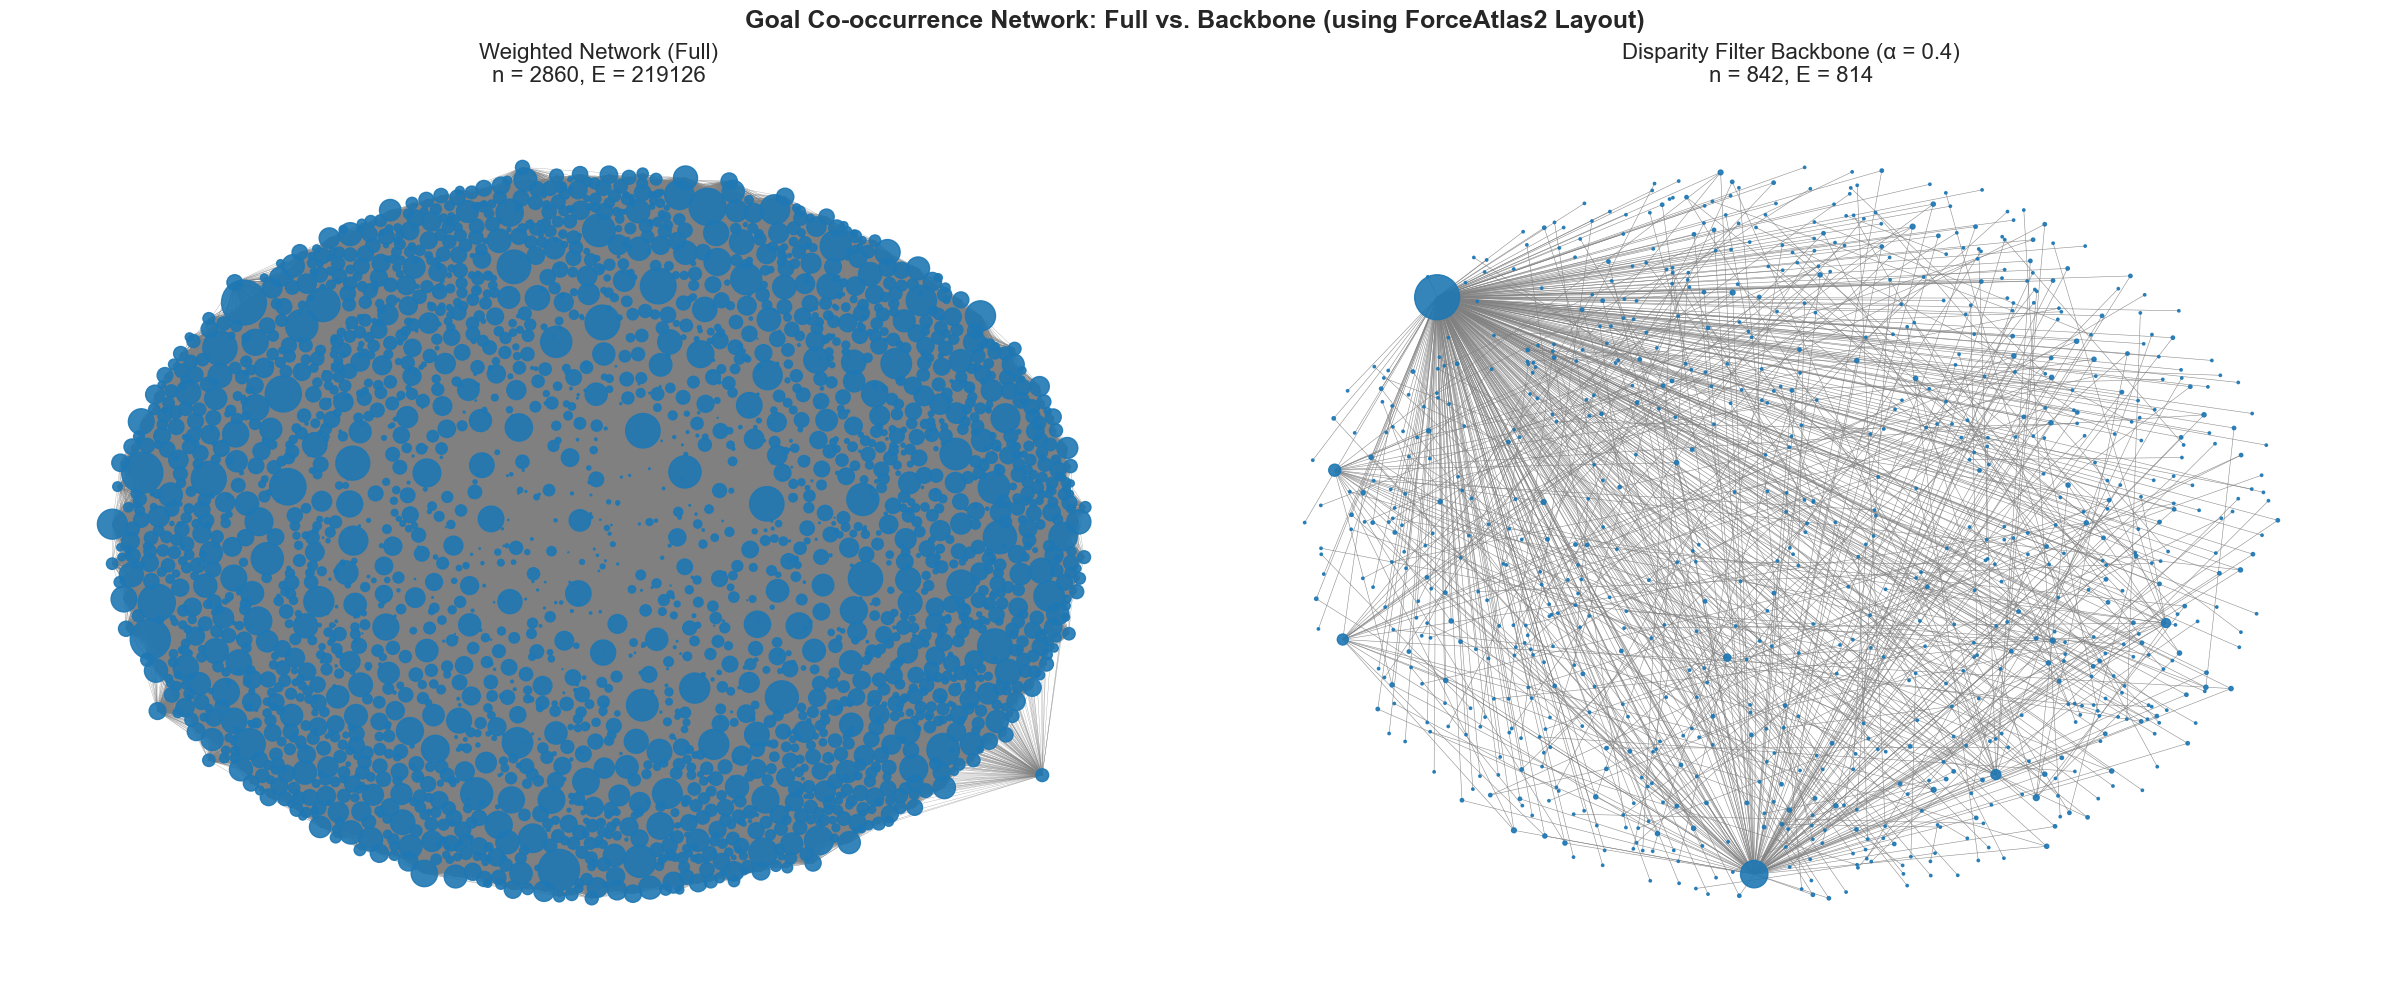


Visualization complete using ForceAtlas2 layout


In [10]:
if G_backbone is not None:
    # Use ForceAtlas2 layout (or spring layout if not available)
    try:
        pos = nx.forceatlas2_layout(
            G_weighted,
            max_iter=1000,
            jitter_tolerance=0.05,
            scaling_ratio=8.0,
            gravity=0.2,
            distributed_action=True,
            strong_gravity=False,
        )
        layout_name = "ForceAtlas2"
    except:
        print("ForceAtlas2 not available, using spring layout instead...")
        pos = nx.spring_layout(G_weighted, k=2, iterations=50, seed=0)
        layout_name = "Spring"
    
    # Compute degree-based node sizes for each graph
    node_sizes_full = [G_weighted.degree(node) * 0.5 for node in G_weighted.nodes()]
    node_sizes_backbone = [G_backbone.degree(node) * 3 for node in G_backbone.nodes()]
    
    # Create side-by-side plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Left: Full weighted network
    nx.draw(
        G_weighted, pos=pos,
        node_size=node_sizes_full,
        edge_color='gray',
        with_labels=False,
        width=0.2,
        alpha=0.9,
        ax=ax1
    )
    ax1.set_title(f"Weighted Network (Full)\nn = {G_weighted.number_of_nodes()}, E = {G_weighted.number_of_edges()}", 
                  fontsize=16)
    
    # Right: Backbone (same layout)
    nx.draw(
        G_backbone, pos=pos,
        node_size=node_sizes_backbone,
        edge_color='grey',
        with_labels=False,
        width=0.4,
        alpha=0.9,
        ax=ax2
    )
    ax2.set_title(f"Disparity Filter Backbone (α = {threshold})\nn = {G_backbone.number_of_nodes()}, E = {G_backbone.number_of_edges()}", 
                  fontsize=16)
    
    fig.suptitle(
        f"Goal Co-occurrence Network: Full vs. Backbone (using {layout_name} Layout)",
        fontsize=18, fontweight='bold', y=0.98
    )
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization complete using {layout_name} layout")
else:
    print("Cannot create visualization - backbone network not created.")


Finally, we visualize the backbone network on its own, color the nodes again according to the categories, and add title labels to the highest degree nodes included.

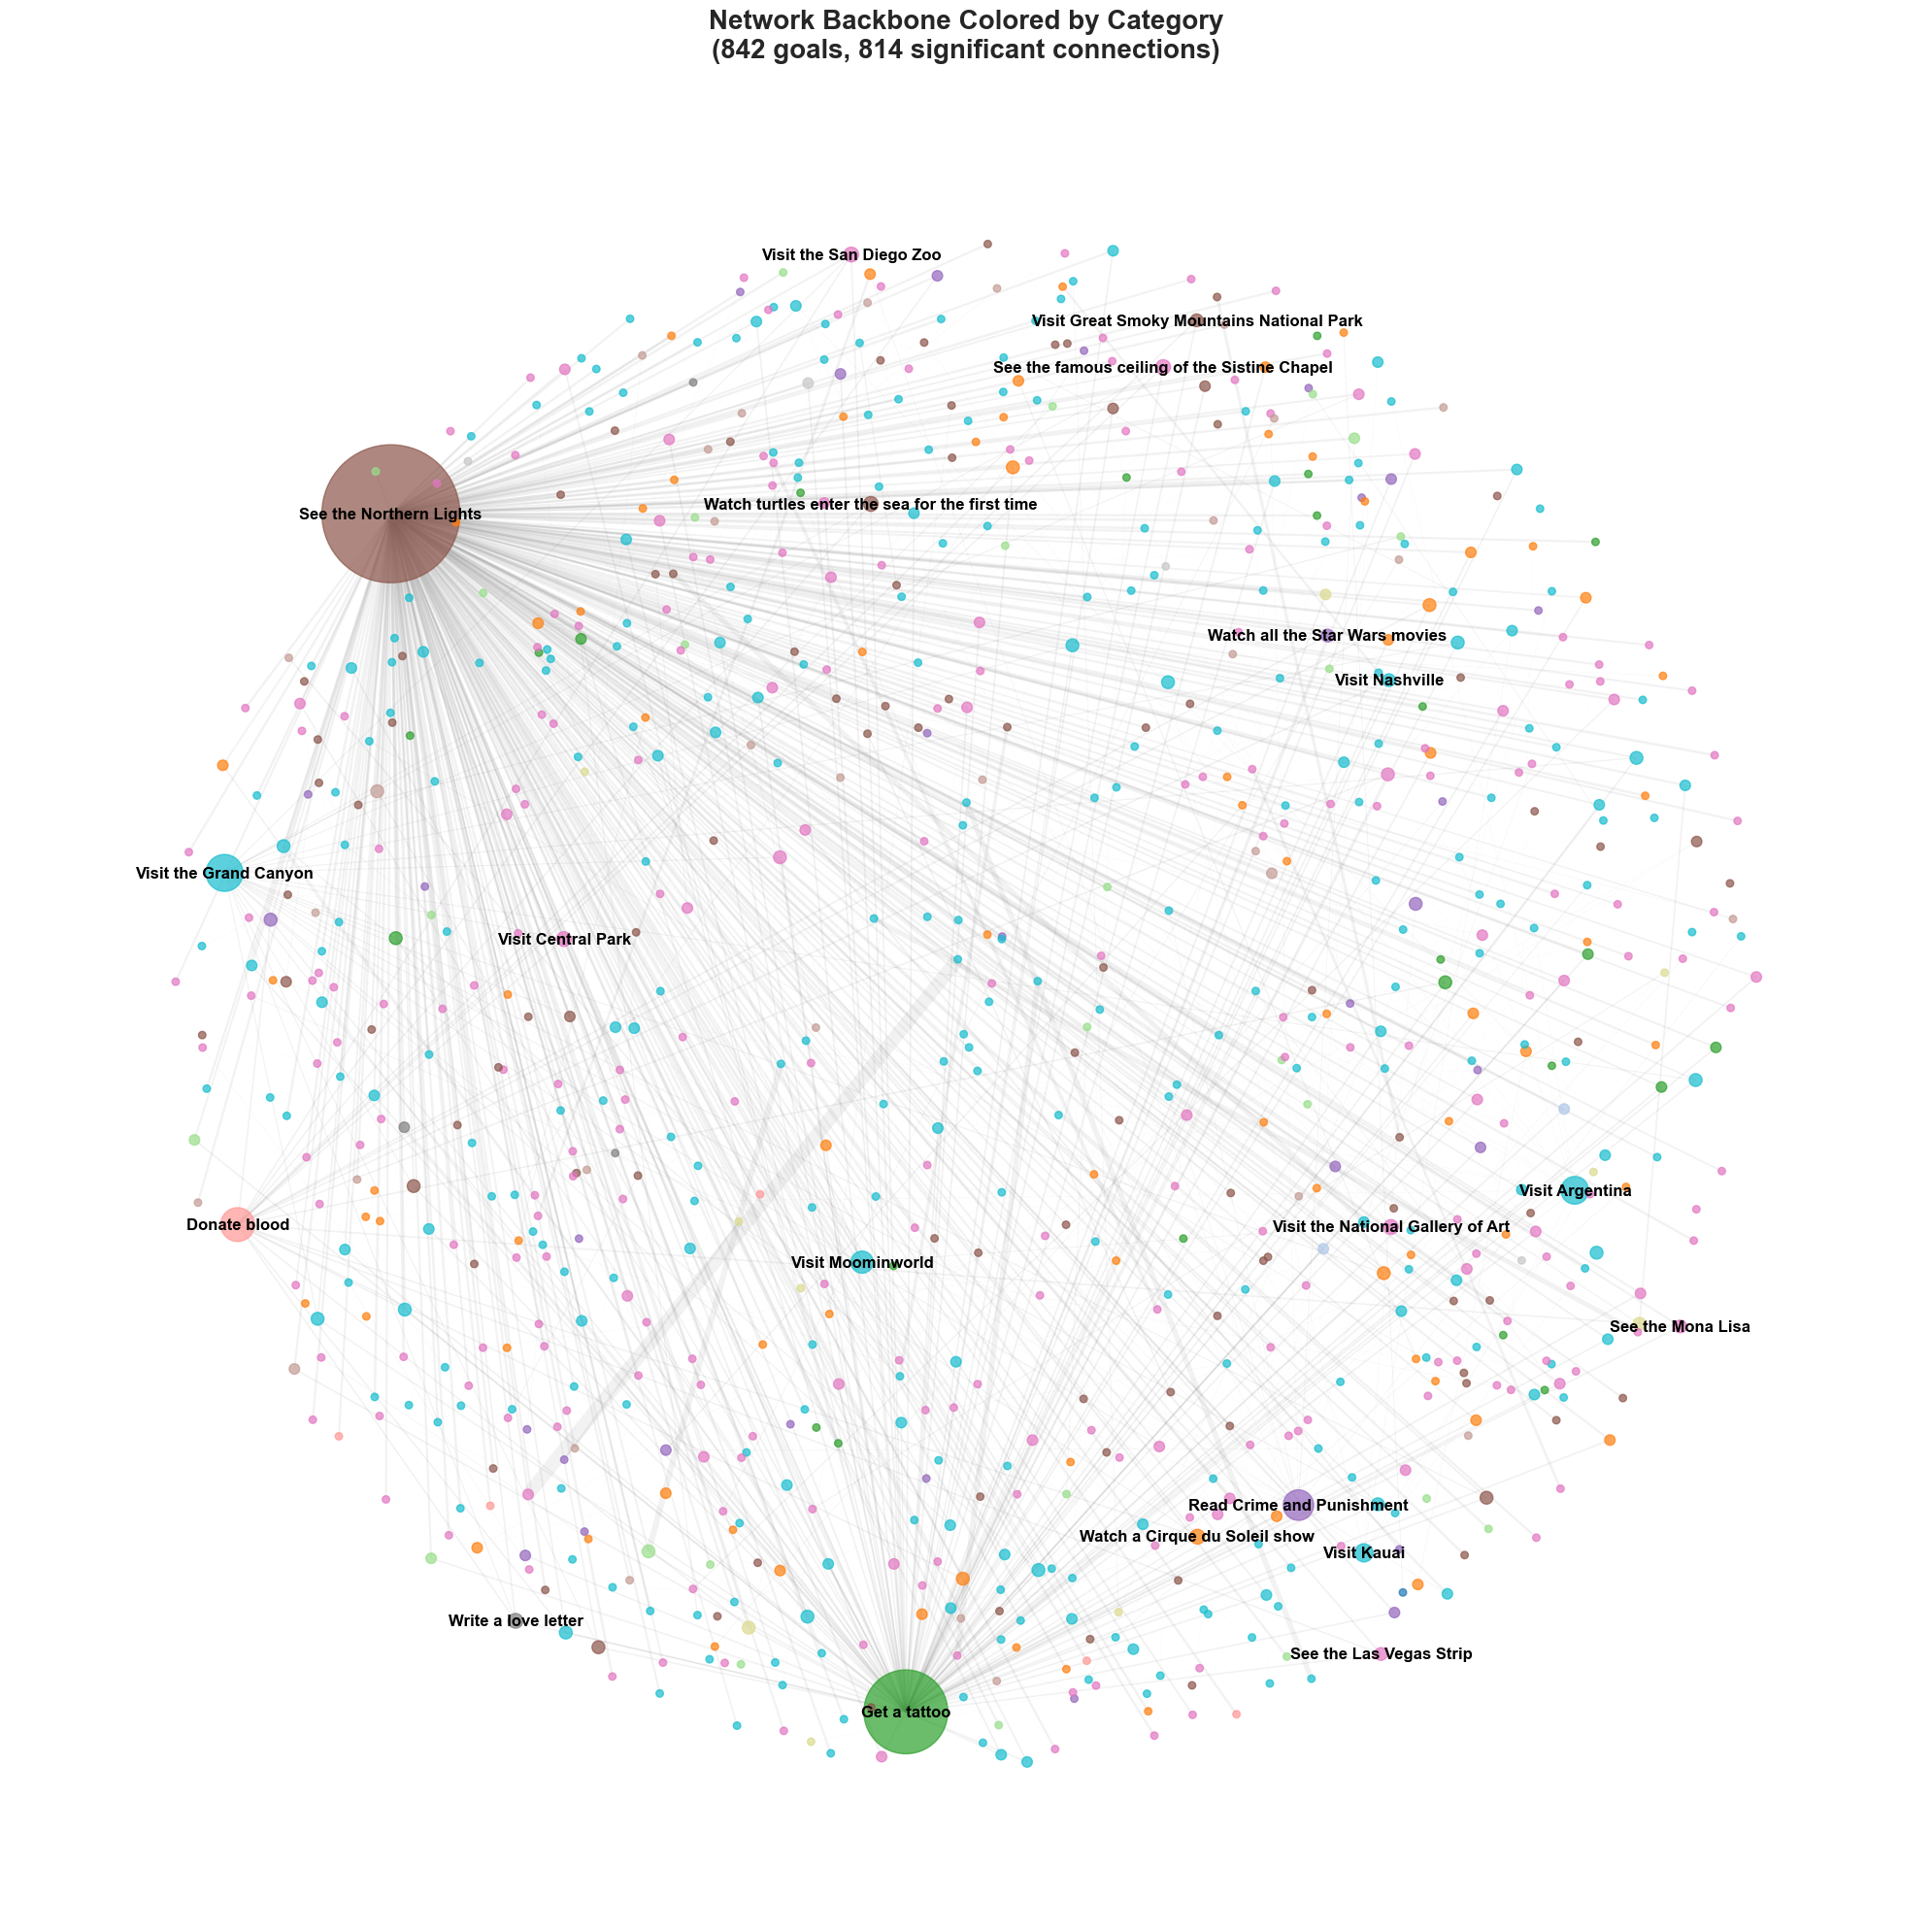

\nCategory colors:
  • Acts of kindness/altruism: 1 goals
  • Creativity: 2 goals
  • Events & concerts: 78 goals
  • Experiences: 24 goals
  • Food: 26 goals
  • Health: 6 goals
  • Media consumption: 32 goals
  • Nature: 93 goals
  • New skills: 32 goals
  • Places of interest: 242 goals
  • Relationships & social life: 4 goals
  • Religion: 4 goals
  • Sports: 10 goals
  • Travel destinations: 288 goals


In [12]:
if G_backbone is not None:
    # Get categories and create color mapping
    categories = []
    for node in G_backbone.nodes():
        cat = G_backbone.nodes[node].get('category', 'Unknown')
        categories.append(cat)
    
    unique_cats = sorted(set(categories))
    if 'Unknown' in unique_cats:
        unique_cats.remove('Unknown')
        unique_cats.append('Unknown')
    
    # Create color map
    cat_colors = {cat: plt.cm.tab20(i/len(unique_cats)) for i, cat in enumerate(unique_cats)}
    node_colors = [cat_colors[cat] for cat in categories]
    
    # Node sizes by degree in backbone
    node_sizes = [G_backbone.degree(node) * 30 for node in G_backbone.nodes()]
    
    # Edge widths proportional to weights
    edge_weights = [G_backbone[u][v].get('nij', 1) for u, v in G_backbone.edges()]
    # Normalize edge widths for better visualization
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 1
    edge_widths = [0.1 + 10.0 * (w - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 0.5 
                   for w in edge_weights]
    
    # Create visualization
    plt.figure(figsize=(20, 20))
    
    # Use same layout as before (focused on backbone nodes)
    pos_backbone = {n: pos[n] for n in G_backbone.nodes() if n in pos}
    
    nx.draw_networkx_nodes(
        G_backbone, pos_backbone,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.7
    )
    
    nx.draw_networkx_edges(
        G_backbone, pos_backbone,
        width=edge_widths,
        alpha=0.1,
        edge_color='gray'
    )
    
    # Add labels for high-degree nodes
    high_degree_nodes = sorted(G_backbone.nodes(), 
                               key=lambda x: G_backbone.degree(x), 
                               reverse=True)[:20]
    labels = {node: G_backbone.nodes[node].get('title', '')
              for node in high_degree_nodes}
    nx.draw_networkx_labels(G_backbone, pos_backbone, labels, 
                           font_size=12, font_weight='bold')
    
    plt.title(f'Network Backbone Colored by Category\n({G_backbone.number_of_nodes()} goals, {G_backbone.number_of_edges()} significant connections)',
              fontsize=20, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print legend
    print("\\nCategory colors:")
    for cat in [c for c in unique_cats if c != 'Unknown']:
        count = categories.count(cat)
        print(f"  • {cat}: {count} goals")
        
else:
    print("Cannot create visualization - backbone network not created.")